In [1]:
import os
print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/ciciot2023"))
print(os.listdir("/kaggle/input/ciciot2023/CICIOT23")[:5])


['ciciot2023']
['CICIOT23']
['validation', 'test', 'train']


In [2]:
import torch

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA Available: False


In [3]:
import os
import glob
import numpy as np
import pandas as pd

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
DATA_PATH = "/kaggle/input/ciciot2023/CICIOT23/"
print("CSV Files:", len(os.listdir(DATA_PATH)))


CSV Files: 3


In [5]:
import glob
import pandas as pd

csv_files = glob.glob(DATA_PATH + "**/*.csv", recursive=True)

print("Total CSV files found:", len(csv_files))

df_list = []
for file in csv_files:
    try:
        df_list.append(pd.read_csv(file))
    except Exception as e:
        print("Skipped:", file)

df = pd.concat(df_list, ignore_index=True)
print("Dataset Shape:", df.shape)


Total CSV files found: 3
Dataset Shape: (7845673, 47)


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Pehle dekh lo columns kya hain
print("Columns in DataFrame:", df.columns)

# Auto-detect Label column
label_col = None
for col in df.columns:
    if "label" in col.lower() or "class" in col.lower() or "category" in col.lower():
        label_col = col
        break

if label_col is None:
    raise KeyError("No suitable label column found in the DataFrame!")
else:
    print(f"Using column '{label_col}' as Label column.")
    df.rename(columns={label_col: "Label"}, inplace=True)

# Attack mapping
attack_map = {
    "Benign": "Benign",
    "DDoS": "DDoS",
    "DoS": "DoS",
    "Mirai": "Mirai",
    "MITM": "Spoofing",
    "Recon": "Recon",
    "Web": "Web",
    "BruteForce": "BruteForce"
}

# Apply mapping safely
df["Label"] = df["Label"].apply(lambda x: attack_map.get(str(x).split("-")[0], "Unknown"))

# Encode labels
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

NUM_CLASSES = len(le.classes_)
print("Classes:", le.classes_)


Columns in DataFrame: Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')
Using column 'label' as Label column.
Classes: ['DDoS' 'DoS' 'Mirai' 'Recon' 'Spoofing' 'Unknown']


In [7]:
X = df.drop(columns=["Label"]).values
y = df["Label"].values

print("X:", X.shape)
print("y:", y.shape)


X: (7845673, 46)
y: (7845673,)


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)


In [10]:
def make_loader(X, y, batch_size=2048):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    return DataLoader(
        TensorDataset(X, y),
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

train_loader = make_loader(X_train, y_train)
val_loader   = make_loader(X_val, y_val)
test_loader  = make_loader(X_test, y_test)


In [11]:
class TransformerIDS(nn.Module):
    def __init__(self, input_dim, num_classes,
                 heads=4, hidden_dim=512, layers=1):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=heads,
            dim_feedforward=hidden_dim,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=layers
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_fc(x)
        x = x.unsqueeze(1)     # fake sequence length = 1
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerIDS(
    input_dim=46,
    num_classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [13]:
EPOCHS = 7

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {total_loss:.4f}")




/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/7]  Loss: 518.5995
Epoch [2/7]  Loss: 325.3695
Epoch [3/7]  Loss: 362.7457
Epoch [4/7]  Loss: 343.7198
Epoch [5/7]  Loss: 267.1238
Epoch [6/7]  Loss: 332.6650
Epoch [7/7]  Loss: 287.3920


In [14]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9027323971487475
              precision    recall  f1-score   support

        DDoS       0.90      0.99      0.94   1142401
         DoS       0.95      0.51      0.67    271670
       Mirai       1.00      0.99      0.99     88522
       Recon       0.80      0.50      0.62     10646
    Spoofing       0.80      0.61      0.69     10379
     Unknown       0.82      0.94      0.88     45517

    accuracy                           0.90   1569135
   macro avg       0.88      0.76      0.80   1569135
weighted avg       0.91      0.90      0.89   1569135



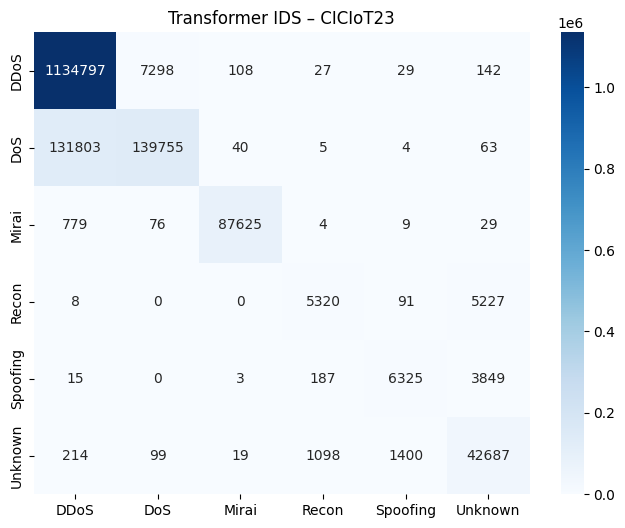

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Transformer IDS – CICIoT23")
plt.show()


In [16]:
import torch

SAVE_PATH = "/kaggle/working/Transformer_CICIoT23.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "scaler": scaler,
    "label_encoder": le,
    "num_classes": NUM_CLASSES
}, SAVE_PATH)

print("Model successfully saved at:", SAVE_PATH)


Model successfully saved at: /kaggle/working/Transformer_CICIoT23.pth


In [17]:
!pip install shap


In [18]:
import shap
import torch
import numpy as np


In [19]:
checkpoint = torch.load(
    "/kaggle/working/Transformer_CICIoT23.pth",
    weights_only=False   # trust your own file
)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


TransformerIDS(
  (input_fc): Linear(in_features=46, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=512, out_features=6, bias=True)
)

In [20]:
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()


In [21]:
# sirf 100 samples background ke liye
background = X_train[:100]


In [22]:
explainer = shap.KernelExplainer(
    model_predict,
    background
)


In [23]:
# sirf 20 samples explain karenge (best practice)
X_explain = X_test[:20]


In [24]:
shap_values = explainer.shap_values(X_explain)


  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
feature_names = df.drop(columns=["Label"]).columns.tolist()


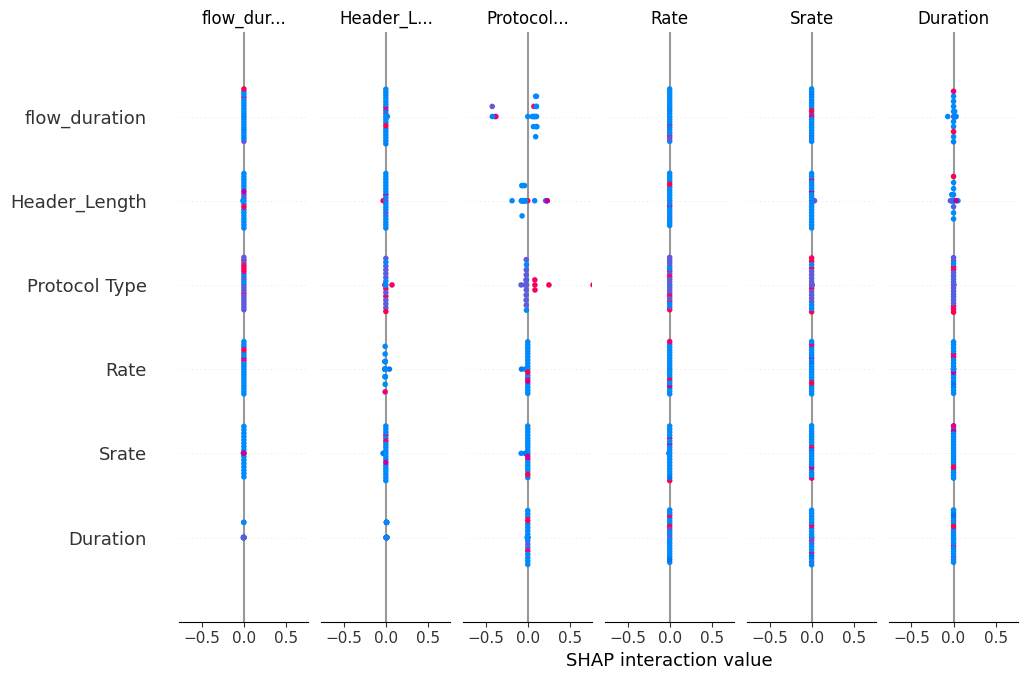

In [26]:
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_names,
    show=True
)


In [27]:
# example: class 0 (Benign ya first attack class)
shap.summary_plot(
    shap_values[0],
    X_explain,
    feature_names=feature_names,
    show=True
)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.